# baseline 1

    설명
    
    1. 데이터셋
    - [X] orgin
    - [O] origin + mol features
    
    2. 전처리
    - [O] stand.
    
    3. lgbm
    - [O] binary classification loss

### import library

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, Fragments, Lipinski, Crippen, MolSurf

%matplotlib inline

import lightgbm as lgbm

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import log_loss, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

### load data

In [29]:
CURRENT_PATH = '/Users/skcc10170/Desktop'

df_train = pd.read_csv(CURRENT_PATH + '/data/org/train_.csv')
df_valid = pd.read_csv(CURRENT_PATH + '/data/org/valid_.csv')
df_test = pd.read_csv(CURRENT_PATH + '/data/org/predict_input.csv')

df_train['type'] = 'train'
df_valid['type'] = 'valid'
df_test['type']  = 'test'

df_tot = pd.concat([df_train, df_valid, df_test], sort=True).reset_index(drop=True)

### feature generating from molecule

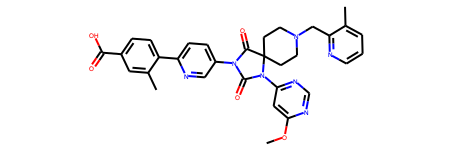

In [30]:
# for test
sample = df_tot['SMILES'][5]
sample = Chem.MolFromSmiles(sample)
sample

In [31]:
from rdkit.Chem import Fragments

In [32]:
Fragments.fr_phos_acid(sample),  Fragments.fr_phos_ester(sample)

(0, 0)

In [33]:
df_tot['myf_NumAtoms']            = df_tot.SMILES.apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
df_tot['myf_NumHeavyAtoms']       = df_tot.SMILES.apply(lambda x: Chem.MolFromSmiles(x).GetNumHeavyAtoms())
df_tot['myf_GetNumBonds']         = df_tot.SMILES.apply(lambda x: Chem.MolFromSmiles(x).GetNumBonds())
df_tot['myf_GetNumHeavyBonds']    = df_tot.SMILES.apply(lambda x: Chem.MolFromSmiles(x).GetNumBonds(onlyHeavy=True))

df_tot['myf_ExactMolWt']          = df_tot.SMILES.apply(lambda x: Descriptors.ExactMolWt(Chem.MolFromSmiles(x)))
df_tot['myf_HeavyAtomMolWt']      = df_tot.SMILES.apply(lambda x: Descriptors.HeavyAtomMolWt(Chem.MolFromSmiles(x)))
df_tot['myf_FpDensityMorgan1']    = df_tot.SMILES.apply(lambda x: Descriptors.FpDensityMorgan1(Chem.MolFromSmiles(x)))
df_tot['myf_FpDensityMorgan2']    = df_tot.SMILES.apply(lambda x: Descriptors.FpDensityMorgan2(Chem.MolFromSmiles(x)))
df_tot['myf_FpDensityMorgan3']    = df_tot.SMILES.apply(lambda x: Descriptors.FpDensityMorgan3(Chem.MolFromSmiles(x)))
df_tot['myf_MaxAbsPartialCharge'] = df_tot.SMILES.apply(lambda x: Descriptors.MaxAbsPartialCharge(Chem.MolFromSmiles(x)))
df_tot['myf_MaxPartialCharge']    = df_tot.SMILES.apply(lambda x: Descriptors.MaxPartialCharge(Chem.MolFromSmiles(x)))
df_tot['myf_MinAbsPartialCharge'] = df_tot.SMILES.apply(lambda x: Descriptors.MinAbsPartialCharge(Chem.MolFromSmiles(x)))
df_tot['myf_MinPartialCharge']    = df_tot.SMILES.apply(lambda x: Descriptors.MinPartialCharge(Chem.MolFromSmiles(x)))
df_tot['myf_MolWt']               = df_tot.SMILES.apply(lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))
df_tot['myf_NumRadicalElectrons'] = df_tot.SMILES.apply(lambda x: Descriptors.NumRadicalElectrons(Chem.MolFromSmiles(x)))
df_tot['myf_NumValenceElectrons'] = df_tot.SMILES.apply(lambda x: Descriptors.NumValenceElectrons(Chem.MolFromSmiles(x)))

df_tot['myf_NumDoubleBondType'] = df_tot.SMILES.apply(lambda x: len([1 for b in Chem.MolFromSmiles(x).GetBonds() if b.GetBondTypeAsDouble() == 1.0]))


df_tot['myf_NumAromaticCarbocycles']   = df_tot.SMILES.apply(lambda x: Lipinski.NumAromaticCarbocycles(Chem.MolFromSmiles(x)))
df_tot['myf_MolLogP']   = df_tot.SMILES.apply(lambda x: Crippen.MolLogP(Chem.MolFromSmiles(x)))
df_tot['myf_PEOE_VSA1']   = df_tot.SMILES.apply(lambda x: MolSurf.PEOE_VSA1(Chem.MolFromSmiles(x)))

In [34]:
df_tot['myf_FractionCSP3']              = df_tot.SMILES.apply(lambda x: Lipinski.FractionCSP3(Chem.MolFromSmiles(x)))
df_tot['myf_NHOHCount']                 = df_tot.SMILES.apply(lambda x: Lipinski.NHOHCount(Chem.MolFromSmiles(x)))
df_tot['myf_NOCount']                   = df_tot.SMILES.apply(lambda x: Lipinski.NOCount(Chem.MolFromSmiles(x)))
df_tot['myf_NumAliphaticCarbocycles']   = df_tot.SMILES.apply(lambda x: Lipinski.NumAliphaticCarbocycles(Chem.MolFromSmiles(x)))
df_tot['myf_NumAliphaticHeterocycles']  = df_tot.SMILES.apply(lambda x: Lipinski.NumAliphaticHeterocycles(Chem.MolFromSmiles(x)))
df_tot['myf_NumAliphaticRings']         = df_tot.SMILES.apply(lambda x: Lipinski.NumAliphaticRings(Chem.MolFromSmiles(x)))
df_tot['myf_NumAromaticCarbocycles']    = df_tot.SMILES.apply(lambda x: Lipinski.NumAromaticCarbocycles(Chem.MolFromSmiles(x)))
df_tot['myf_NumAromaticHeterocycles']   = df_tot.SMILES.apply(lambda x: Lipinski.NumAromaticHeterocycles(Chem.MolFromSmiles(x)))
df_tot['myf_NumAromaticRings']          = df_tot.SMILES.apply(lambda x: Lipinski.NumAromaticRings(Chem.MolFromSmiles(x)))
df_tot['myf_NumHAcceptors']             = df_tot.SMILES.apply(lambda x: Lipinski.NumHAcceptors(Chem.MolFromSmiles(x)))
df_tot['myf_NumHDonors']                = df_tot.SMILES.apply(lambda x: Lipinski.NumHDonors(Chem.MolFromSmiles(x)))
df_tot['myf_NumHeteroatoms']            = df_tot.SMILES.apply(lambda x: Lipinski.NumHeteroatoms(Chem.MolFromSmiles(x)))
df_tot['myf_NumRotatableBonds']         = df_tot.SMILES.apply(lambda x: Lipinski.NumRotatableBonds(Chem.MolFromSmiles(x)))
df_tot['myf_NumSaturatedCarbocycles']   = df_tot.SMILES.apply(lambda x: Lipinski.NumSaturatedCarbocycles(Chem.MolFromSmiles(x)))
df_tot['myf_NumSaturatedHeterocycles']  = df_tot.SMILES.apply(lambda x: Lipinski.NumSaturatedHeterocycles(Chem.MolFromSmiles(x)))
df_tot['myf_NumSaturatedRings']         = df_tot.SMILES.apply(lambda x: Lipinski.NumSaturatedRings(Chem.MolFromSmiles(x)))
df_tot['myf_RingCount']                 = df_tot.SMILES.apply(lambda x: Lipinski.RingCount(Chem.MolFromSmiles(x)))

In [35]:
df_tot['myf_fr_phos_acid']    = df_tot.SMILES.apply(lambda x: Fragments.fr_phos_acid(Chem.MolFromSmiles(x)))
df_tot['myf_fr_phos_ester']   = df_tot.SMILES.apply(lambda x: Fragments.fr_phos_ester(Chem.MolFromSmiles(x)))

df_tot['myf_fr_Al_COO']   = df_tot.SMILES.apply(lambda x: Fragments.fr_Al_COO(Chem.MolFromSmiles(x)))
df_tot['myf_fr_Al_OH']   = df_tot.SMILES.apply(lambda x: Fragments.fr_Al_OH(Chem.MolFromSmiles(x)))
df_tot['myf_fr_Al_OH_noTert']   = df_tot.SMILES.apply(lambda x: Fragments.fr_Al_OH_noTert(Chem.MolFromSmiles(x)))
df_tot['myf_fr_ArN']   = df_tot.SMILES.apply(lambda x: Fragments.fr_ArN(Chem.MolFromSmiles(x)))
df_tot['myf_fr_Ar_COO']   = df_tot.SMILES.apply(lambda x: Fragments.fr_Ar_COO(Chem.MolFromSmiles(x)))
df_tot['myf_fr_Ar_N']   = df_tot.SMILES.apply(lambda x: Fragments.fr_Ar_N(Chem.MolFromSmiles(x)))
df_tot['myf_fr_Ar_NH']   = df_tot.SMILES.apply(lambda x: Fragments.fr_Ar_NH(Chem.MolFromSmiles(x)))
df_tot['myf_fr_Ar_OH']   = df_tot.SMILES.apply(lambda x: Fragments.fr_Ar_OH(Chem.MolFromSmiles(x)))
df_tot['myf_fr_COO']   = df_tot.SMILES.apply(lambda x: Fragments.fr_COO(Chem.MolFromSmiles(x)))
df_tot['myf_fr_COO2']   = df_tot.SMILES.apply(lambda x: Fragments.fr_COO2(Chem.MolFromSmiles(x)))
df_tot['myf_fr_C_O']   = df_tot.SMILES.apply(lambda x: Fragments.fr_C_O(Chem.MolFromSmiles(x)))
df_tot['myf_fr_C_O_noCOO']   = df_tot.SMILES.apply(lambda x: Fragments.fr_C_O_noCOO(Chem.MolFromSmiles(x)))
df_tot['myf_fr_C_S']   = df_tot.SMILES.apply(lambda x: Fragments.fr_C_S(Chem.MolFromSmiles(x)))
df_tot['myf_fr_HOCCN']   = df_tot.SMILES.apply(lambda x: Fragments.fr_HOCCN(Chem.MolFromSmiles(x)))
df_tot['myf_fr_Imine']   = df_tot.SMILES.apply(lambda x: Fragments.fr_Imine(Chem.MolFromSmiles(x)))
df_tot['myf_fr_NH0']   = df_tot.SMILES.apply(lambda x: Fragments.fr_NH0(Chem.MolFromSmiles(x)))
df_tot['myf_fr_NH1']   = df_tot.SMILES.apply(lambda x: Fragments.fr_NH1(Chem.MolFromSmiles(x)))
df_tot['myf_fr_NH2']   = df_tot.SMILES.apply(lambda x: Fragments.fr_NH2(Chem.MolFromSmiles(x)))
df_tot['myf_fr_N_O']   = df_tot.SMILES.apply(lambda x: Fragments.fr_N_O(Chem.MolFromSmiles(x)))
df_tot['myf_fr_Ndealkylation1']   = df_tot.SMILES.apply(lambda x: Fragments.fr_Ndealkylation1(Chem.MolFromSmiles(x)))
df_tot['myf_fr_Ndealkylation2']   = df_tot.SMILES.apply(lambda x: Fragments.fr_Ndealkylation2(Chem.MolFromSmiles(x)))
df_tot['myf_fr_Nhpyrrole']   = df_tot.SMILES.apply(lambda x: Fragments.fr_Nhpyrrole(Chem.MolFromSmiles(x)))
df_tot['myf_fr_SH']   = df_tot.SMILES.apply(lambda x: Fragments.fr_SH(Chem.MolFromSmiles(x)))
df_tot['myf_fr_aldehyde']   = df_tot.SMILES.apply(lambda x: Fragments.fr_aldehyde(Chem.MolFromSmiles(x)))

In [36]:
df_tot['myf_fr_alkyl_carbamate']   = df_tot.SMILES.apply(lambda x: Fragments.fr_alkyl_carbamate(Chem.MolFromSmiles(x)))
df_tot['myf_fr_alkyl_halide']   = df_tot.SMILES.apply(lambda x: Fragments.fr_alkyl_halide(Chem.MolFromSmiles(x)))
df_tot['myf_fr_allylic_oxid']   = df_tot.SMILES.apply(lambda x: Fragments.fr_allylic_oxid(Chem.MolFromSmiles(x)))
df_tot['myf_fr_amide']   = df_tot.SMILES.apply(lambda x: Fragments.fr_amide(Chem.MolFromSmiles(x)))
df_tot['myf_fr_amidine']   = df_tot.SMILES.apply(lambda x: Fragments.fr_amidine(Chem.MolFromSmiles(x)))
df_tot['myf_fr_aniline']   = df_tot.SMILES.apply(lambda x: Fragments.fr_aniline(Chem.MolFromSmiles(x)))
df_tot['myf_fr_aryl_methyl']   = df_tot.SMILES.apply(lambda x: Fragments.fr_aryl_methyl(Chem.MolFromSmiles(x)))
df_tot['myf_fr_azide']   = df_tot.SMILES.apply(lambda x: Fragments.fr_azide(Chem.MolFromSmiles(x)))
df_tot['myf_fr_azo']   = df_tot.SMILES.apply(lambda x: Fragments.fr_azo(Chem.MolFromSmiles(x)))
df_tot['myf_fr_barbitur']   = df_tot.SMILES.apply(lambda x: Fragments.fr_barbitur(Chem.MolFromSmiles(x)))
df_tot['myf_fr_benzene']   = df_tot.SMILES.apply(lambda x: Fragments.fr_benzene(Chem.MolFromSmiles(x)))
df_tot['myf_fr_benzodiazepine']   = df_tot.SMILES.apply(lambda x: Fragments.fr_benzodiazepine(Chem.MolFromSmiles(x)))
df_tot['myf_fr_bicyclic']   = df_tot.SMILES.apply(lambda x: Fragments.fr_bicyclic(Chem.MolFromSmiles(x)))
df_tot['myf_fr_diazo']   = df_tot.SMILES.apply(lambda x: Fragments.fr_diazo(Chem.MolFromSmiles(x)))
df_tot['myf_fr_dihydropyridine']   = df_tot.SMILES.apply(lambda x: Fragments.fr_dihydropyridine(Chem.MolFromSmiles(x)))
df_tot['myf_fr_epoxide']   = df_tot.SMILES.apply(lambda x: Fragments.fr_epoxide(Chem.MolFromSmiles(x)))
df_tot['myf_fr_ester']   = df_tot.SMILES.apply(lambda x: Fragments.fr_ester(Chem.MolFromSmiles(x)))
df_tot['myf_fr_ether']   = df_tot.SMILES.apply(lambda x: Fragments.fr_ether(Chem.MolFromSmiles(x)))
df_tot['myf_fr_furan']   = df_tot.SMILES.apply(lambda x: Fragments.fr_furan(Chem.MolFromSmiles(x)))
df_tot['myf_fr_guanido']   = df_tot.SMILES.apply(lambda x: Fragments.fr_guanido(Chem.MolFromSmiles(x)))
df_tot['myf_fr_halogen']   = df_tot.SMILES.apply(lambda x: Fragments.fr_halogen(Chem.MolFromSmiles(x)))

df_tot['myf_fr_hdrzine']   = df_tot.SMILES.apply(lambda x: Fragments.fr_hdrzine(Chem.MolFromSmiles(x)))
df_tot['myf_fr_hdrzone']   = df_tot.SMILES.apply(lambda x: Fragments.fr_hdrzone(Chem.MolFromSmiles(x)))
df_tot['myf_fr_imidazole']   = df_tot.SMILES.apply(lambda x: Fragments.fr_imidazole(Chem.MolFromSmiles(x)))
df_tot['myf_fr_imide']   = df_tot.SMILES.apply(lambda x: Fragments.fr_imide(Chem.MolFromSmiles(x)))
df_tot['myf_fr_isocyan']   = df_tot.SMILES.apply(lambda x: Fragments.fr_isocyan(Chem.MolFromSmiles(x)))

df_tot['myf_fr_isothiocyan']   = df_tot.SMILES.apply(lambda x: Fragments.fr_isothiocyan(Chem.MolFromSmiles(x)))
df_tot['myf_fr_ketone']   = df_tot.SMILES.apply(lambda x: Fragments.fr_ketone(Chem.MolFromSmiles(x)))
df_tot['myf_fr_ketone_Topliss']   = df_tot.SMILES.apply(lambda x: Fragments.fr_ketone_Topliss(Chem.MolFromSmiles(x)))
df_tot['myf_fr_lactam']   = df_tot.SMILES.apply(lambda x: Fragments.fr_lactam(Chem.MolFromSmiles(x)))
df_tot['myf_fr_lactone']   = df_tot.SMILES.apply(lambda x: Fragments.fr_lactone(Chem.MolFromSmiles(x)))
df_tot['myf_fr_methoxy']   = df_tot.SMILES.apply(lambda x: Fragments.fr_methoxy(Chem.MolFromSmiles(x)))
df_tot['myf_fr_morpholine']   = df_tot.SMILES.apply(lambda x: Fragments.fr_morpholine(Chem.MolFromSmiles(x)))
df_tot['myf_fr_nitrile']   = df_tot.SMILES.apply(lambda x: Fragments.fr_nitrile(Chem.MolFromSmiles(x)))
df_tot['myf_fr_nitro']   = df_tot.SMILES.apply(lambda x: Fragments.fr_nitro(Chem.MolFromSmiles(x)))
df_tot['myf_fr_nitro_arom']   = df_tot.SMILES.apply(lambda x: Fragments.fr_nitro_arom(Chem.MolFromSmiles(x)))

df_tot['myf_fr_nitro_arom_nonortho']   = df_tot.SMILES.apply(lambda x: Fragments.fr_nitro_arom_nonortho(Chem.MolFromSmiles(x)))
df_tot['myf_fr_nitroso']   = df_tot.SMILES.apply(lambda x: Fragments.fr_nitroso(Chem.MolFromSmiles(x)))

df_tot['myf_fr_oxazole']   = df_tot.SMILES.apply(lambda x: Fragments.fr_oxazole(Chem.MolFromSmiles(x)))
df_tot['myf_fr_oxime']   = df_tot.SMILES.apply(lambda x: Fragments.fr_oxime(Chem.MolFromSmiles(x)))
df_tot['myf_fr_para_hydroxylation']   = df_tot.SMILES.apply(lambda x: Fragments.fr_para_hydroxylation(Chem.MolFromSmiles(x)))
df_tot['myf_fr_phenol']   = df_tot.SMILES.apply(lambda x: Fragments.fr_phenol(Chem.MolFromSmiles(x)))

df_tot['myf_fr_phenol_noOrthoHbond']   = df_tot.SMILES.apply(lambda x: Fragments.fr_phenol_noOrthoHbond(Chem.MolFromSmiles(x)))
df_tot['myf_fr_phos_acid']   = df_tot.SMILES.apply(lambda x: Fragments.fr_phos_acid(Chem.MolFromSmiles(x)))
df_tot['myf_fr_phos_ester']   = df_tot.SMILES.apply(lambda x: Fragments.fr_phos_ester(Chem.MolFromSmiles(x)))
df_tot['myf_fr_piperdine']   = df_tot.SMILES.apply(lambda x: Fragments.fr_piperdine(Chem.MolFromSmiles(x)))
df_tot['myf_fr_piperzine']   = df_tot.SMILES.apply(lambda x: Fragments.fr_piperzine(Chem.MolFromSmiles(x)))
df_tot['myf_fr_priamide']   = df_tot.SMILES.apply(lambda x: Fragments.fr_priamide(Chem.MolFromSmiles(x)))
df_tot['myf_fr_prisulfonamd']   = df_tot.SMILES.apply(lambda x: Fragments.fr_prisulfonamd(Chem.MolFromSmiles(x)))
df_tot['myf_fr_pyridine']   = df_tot.SMILES.apply(lambda x: Fragments.fr_pyridine(Chem.MolFromSmiles(x)))
df_tot['myf_fr_quatN']   = df_tot.SMILES.apply(lambda x: Fragments.fr_quatN(Chem.MolFromSmiles(x)))
df_tot['myf_fr_sulfide']   = df_tot.SMILES.apply(lambda x: Fragments.fr_sulfide(Chem.MolFromSmiles(x)))
df_tot['myf_fr_sulfonamd']   = df_tot.SMILES.apply(lambda x: Fragments.fr_sulfonamd(Chem.MolFromSmiles(x)))

df_tot['myf_fr_sulfone']   = df_tot.SMILES.apply(lambda x: Fragments.fr_sulfone(Chem.MolFromSmiles(x)))
df_tot['myf_fr_term_acetylene']   = df_tot.SMILES.apply(lambda x: Fragments.fr_term_acetylene(Chem.MolFromSmiles(x)))
df_tot['myf_fr_tetrazole']   = df_tot.SMILES.apply(lambda x: Fragments.fr_tetrazole(Chem.MolFromSmiles(x)))
df_tot['myf_fr_thiazole']   = df_tot.SMILES.apply(lambda x: Fragments.fr_thiazole(Chem.MolFromSmiles(x)))
df_tot['myf_ fr_thiocyan']   = df_tot.SMILES.apply(lambda x: Fragments.fr_thiocyan(Chem.MolFromSmiles(x)))

df_tot['myf_fr_thiophene']   = df_tot.SMILES.apply(lambda x: Fragments.fr_thiophene(Chem.MolFromSmiles(x)))
df_tot['myf_fr_unbrch_alkane']   = df_tot.SMILES.apply(lambda x: Fragments.fr_unbrch_alkane(Chem.MolFromSmiles(x)))
df_tot['myf_fr_urea']   = df_tot.SMILES.apply(lambda x: Fragments.fr_urea(Chem.MolFromSmiles(x)))

### get dummy

In [37]:
df_tot2 = df_tot.deepcopy()
cols    = df_tot2.columns

for col in list(cols[cols.str.contains('myf_')]):
    if len(df_tot2[col].value_counts()) > 2 and len(df_tot2[col].value_counts()) < 10:
        df_tot2 = df_tot2.join(pd.get_dummies(df_tot2[col],prefix=str(col)))
        del df_tot2[col]

--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--


In [59]:
df_tot2.columns

Index(['MolWt', 'SMILES', 'clogp', 'ecfp_0', 'ecfp_1', 'ecfp_10', 'ecfp_100',
       'ecfp_1000', 'ecfp_1001', 'ecfp_1002',
       ...
       'myf_fr_thiophene_1', 'myf_fr_thiophene_2', 'myf_fr_unbrch_alkane_0',
       'myf_fr_unbrch_alkane_1', 'myf_fr_unbrch_alkane_2',
       'myf_fr_unbrch_alkane_3', 'myf_fr_unbrch_alkane_4',
       'myf_fr_unbrch_alkane_5', 'myf_fr_unbrch_alkane_6',
       'myf_fr_unbrch_alkane_8'],
      dtype='object', length=3438)

### data feature

In [45]:
df_tot_org = df_tot.copy()
df_tot = df_tot2.copy()

AttributeError: 'DataFrame' object has no attribute 'deepcopy'

In [48]:
len(df_tot.columns), len(df_tot_org)

(3438, 9276)

In [60]:
# find all columns
cols = df_tot.columns

# smiles code
cols_smiles = 'SMILES'

# node-edge level (3 footprints)
cols_ecfp = list(cols[cols.str.contains('ecfp_')]) # ecfp 1024개
cols_fcfp = list(cols[cols.str.contains('fcfp_')]) # fcfp 1024개
cols_ptfp = list(cols[cols.str.contains('ptfp_')]) # ptfp 1024개

# graph level
cols_mol = ['MolWt', 'clogp', 'sa_score', 'qed']

### new features
cols_new_f = list(cols[cols.str.contains('myf_')])

# input cols
cols_input1 = cols_ecfp + cols_fcfp + cols_ptfp # don't have to normalize
cols_input2 = cols_mol + cols_new_f # have to normalize
cols_input  = cols_input1 + cols_input2

# label
cols_label = 'label'

### CV start!

In [61]:
n_splits     = 5
random_state = 2021
random_seed  = 2022
data_random_seed = 2023
feature_fraction_seed = 2024

num_test     = len(df_test) # 927

kfold = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)

In [62]:
# x_train, y_train = df_train[cols_input].values, df_train[cols_label].values
# x_valid, y_valid = df_valid[cols_input].values, df_valid[cols_label].values
# x_test            = df_test[cols_input].values

x_train, y_train = df_tot.loc[df_tot['type']=='train', cols_input].values, df_train[cols_label].values
x_valid, y_valid = df_tot.loc[df_tot['type']=='valid', cols_input].values, df_valid[cols_label].values
x_test           = df_tot.loc[df_tot['type']=='test', cols_input].values

trainset_x = np.vstack([x_train, x_valid])
trainset_y = np.hstack([y_train, y_valid])

In [63]:
x_test.shape, x_train.shape

((927, 3435), (6680, 3435))

In [53]:
{"objective":{"0":"binary"},"learning_rate":{"0":0.01},"num_leaves":{"0":90},
 "feature_fraction":{"0":0.9},"bagging_fraction":{"0":0.8},"bagging_freq":{"0":1},
 "boosting_type":{"0":"dart"},"metric":{"0":["binary_logloss"]},"max_depth":{"0":22}}

{'objective': {'0': 'binary'},
 'learning_rate': {'0': 0.01},
 'num_leaves': {'0': 90},
 'feature_fraction': {'0': 0.9},
 'bagging_fraction': {'0': 0.8},
 'bagging_freq': {'0': 1},
 'boosting_type': {'0': 'dart'},
 'metric': {'0': ['binary_logloss']},
 'max_depth': {'0': 22}}

In [69]:
params = {
    'objective' :'binary',
    'learning_rate' : 0.02,
    'num_leaves' : 128,
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.7485324439812423, 
    'bagging_freq':8,
    'boosting_type' : 'dart',
    'metric': {'binary_logloss'},
    'max_depth' : 24,
    "min_data_in_leaf": 33
}

In [70]:
val_f1, val_acc, val_loss = [], [], []
results = np.zeros((kfold.n_splits, num_test), dtype=np.float)
prob_results = np.zeros(len(trainset_x), dtype=np.float)

for i, (train_idx, valid_idx) in enumerate(kfold.split(trainset_x, trainset_y)):
    
    # 데이터셋 나눔(train, valid & x,y)
    x_train, y_train = trainset_x[train_idx], trainset_y[train_idx]
    x_valid, y_valid = trainset_x[valid_idx], trainset_y[valid_idx]
    x_test           = df_tot.loc[df_tot['type']=='test', cols_input].values
    
    # 트레인셋 기준으로 평균값, 표준편차 계산
    ## 수치형 변수 기준
    ### baseline : cols_input2(수치형)
    cktpt = len(cols_input2)
    tr_mean, tr_std = x_train[:, -cktpt:].mean(axis=0), x_train[:, -cktpt:].std(axis=0)
    tr_max, tr_min  = x_train[:, -cktpt:].max(axis=0), x_train[:, -cktpt:].min(axis=0)
    
    # train/valid (std)
    x_train[:,-cktpt:] = (x_train[:,-cktpt:] - tr_mean) / (tr_std + 1e-5)
    x_valid[:,-cktpt:] = (x_valid[:,-cktpt:] - tr_mean) / (tr_std + 1e-5)
    x_test[:,-cktpt:]  = (x_test[:,-cktpt:]  - tr_mean) / (tr_std + 1e-5)

    # train/valid (minmax)    
#     x_train[:,-cktpt:] = (x_train[:,-cktpt:] - tr_min) / (tr_max - tr_min + 1e-5)
#     x_valid[:,-cktpt:] = (x_valid[:,-cktpt:] - tr_min) / (tr_std - tr_min + 1e-5)
#     x_test[:,-cktpt:]  = (x_test[:,-cktpt:]  - tr_min) / (tr_std - tr_min + 1e-5)
    
    d_train = lgbm.Dataset(x_train, y_train)
    d_valid = lgbm.Dataset(x_valid, y_valid)
    
    model = lgbm.train(params, d_train, 30000, valid_sets=[d_valid, d_train], valid_names=['val', 'train'],
                       verbose_eval=100, early_stopping_rounds=100)
    
    valid_pred_prob = model.predict(x_valid, num_iteration=model.best_iteration)
    prob_results[valid_idx] = valid_pred_prob
    y_valid_pred = (valid_pred_prob > 0.5).astype(int)
    
    f1 = f1_score(y_valid, y_valid_pred)
    acc = accuracy_score(y_valid, y_valid_pred)
    loss = model.best_score['val']['binary_logloss']
    
    print(f'Fold {i} | Valid Accuracy: {acc}, F1 Score: {f1}')

    results[i] = model.predict(x_test, num_iteration=model.best_iteration)
    val_f1.append(f1)
    val_acc.append(acc)
    val_loss.append(loss)

print(f'Valid Accuracy: {np.mean(val_acc)}, F1 Score: {np.mean(val_f1)}')

Training until validation scores don't improve for 100 rounds.
[100]	train's binary_logloss: 0.497206	val's binary_logloss: 0.540714
[200]	train's binary_logloss: 0.431597	val's binary_logloss: 0.497091
[300]	train's binary_logloss: 0.368685	val's binary_logloss: 0.464261
[400]	train's binary_logloss: 0.319525	val's binary_logloss: 0.444367
[500]	train's binary_logloss: 0.274305	val's binary_logloss: 0.428774
[600]	train's binary_logloss: 0.25701	val's binary_logloss: 0.422366
[700]	train's binary_logloss: 0.229147	val's binary_logloss: 0.414629
[800]	train's binary_logloss: 0.213475	val's binary_logloss: 0.413391
[900]	train's binary_logloss: 0.191167	val's binary_logloss: 0.408776
[1000]	train's binary_logloss: 0.177623	val's binary_logloss: 0.409392
Early stopping, best iteration is:
[935]	train's binary_logloss: 0.187565	val's binary_logloss: 0.408468
Fold 0 | Valid Accuracy: 0.8096947935368043, F1 Score: 0.8282937365010798
Training until validation scores don't improve for 100 rou

In [72]:
df_result = df_tot[['type','SMILES','label']].copy()
df_result.loc[:, '1'] = pd.Series(np.hstack([prob_results, results.mean(axis=0)]))
df_result.loc[:, 'predict'] = (df_result['1'] > 0.5).astype(int)
df_result = df_result[['type', 'SMILES', '1', 'label', 'predict']]

In [73]:
OUTPUT_PATH = '/Users/skcc10170/Desktop/data/model_result/'
output_name = 'model_acc_' + "{:.4f}".format(np.mean(val_acc)) \
                           + '_f1_' + "{:.4f}".format(np.mean(val_f1)) \
                           + '_loss_' + "{:.4f}".format(np.mean(val_loss)) \
                           + '.csv'

In [74]:
df_result.to_csv(OUTPUT_PATH + output_name)
print(output_name)

model_acc_0.8074_f1_0.8268_loss_0.4154.csv
